[View in Colaboratory](https://colab.research.google.com/github/3to80/DeepLearning/blob/master/Image_classifier_GoogleNet.ipynb)

#Utility code

In [0]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os
import tensorflow as tf
import sklearn

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

# Data 준비

- 동물 이미지 받기
  - matplotlib.image.imread() or scipy.misc.imread
- Image preproceccing
  - 299 * 299 * 3(RGB) 로 변경
  - Image 픽셀 값을 -1. ~ 1.사이로 변경
- Stanford STL10 이용
  - local에서 받아 구글 드라이브 업로드

In [0]:
WIDTH = 299
HEIGHT = 299
CHANNELS = 3


In [0]:
import matplotlib.image as mpimg
import scipy.misc as misc

import os
def get_img(img_path):
  if not os.path.isfile(img_path):
    sys.stdout.write("No file or path")
    sys,stdout.flush()
    return
  
  load_img= misc.imread(img_path)[:, :, :CHANNELS]
  return load_img

def adapt_inception(img):
  return 2*img -1




/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


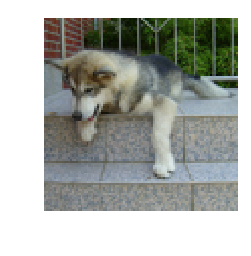

In [64]:
test_image = get_img("img/617.png")

plt.imshow(test_image)
plt.axis("off")
plt.show()

# GoogleNet download
- download checkpoint
  - python을 이용
  - URL, CHECKPOINT , PATH 변수 설정

In [0]:
import sys
import tarfile
from six.moves import urllib #Python 2, 3간 공용 lib 이름 호환성위해 six.moves  

In [0]:
# 다운 받을 url, model path 설정
TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"

INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

RESNET_PATH = os.path.join("datasets", "resnet")
RESENT_V2_200_PATH = os.path.join(RESNET_PATH, "resnet_v2_200.ckpt")

In [0]:

# monitoring downloading progress
def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

#DEFAULT INCEPTION V3
def fetch_pretrained_CNN(url=INCEPTION_V3_URL, path=INCEPTION_PATH,
                        tgz_path = "inception_v3.tgz", chpt_path = INCEPTION_V3_CHECKPOINT_PATH):
    if os.path.exists(chpt_path):
        return
    os.makedirs(path, exist_ok=True)
    
    tgz_path = os.path.join(path, tgz_path)
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)

    # uncompressing
    model_tgz = tarfile.open(tgz_path)
    model_tgz.extractall(path=path)    
    model_tgz.close()    
    os.remove(tgz_path)

In [11]:
fetch_pretrained_CNN()

Downloading: 100%

In [0]:
# 정규표현식 사용 위해 
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [0]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [16]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [0]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_name.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [0]:

class_names = ["background"] + load_class_names()

In [136]:

# (299, 299, 3) (299, 299, 3 ) -> (2, 299, 299, 3) 
X_test = []
X_origin = []
for img in os.listdir("img"):
  test_image = get_img(os.path.join("img", img))
  X_origin.append(test_image)

  test_image = misc.imresize(test_image, (HEIGHT,WIDTH,CHANNELS), 'cubic')
  test_image = test_image / 128 -1
  X_test.append(test_image)
  
X_test = np.array(X_test)
print(X_test.shape)
# print(X_test[0])




/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(32, 299, 299, 3)


INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


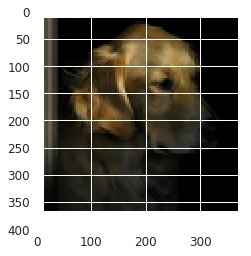

golden retriever: 77.60%
Irish setter, red setter: 1.44%
Brittany spaniel: 1.15%
Sussex spaniel: 0.87%
flat-coated retriever: 0.80%


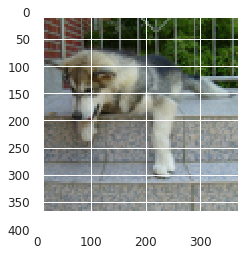

malamute, malemute, Alaskan malamute: 92.61%
Siberian husky: 3.07%
Eskimo dog, husky: 0.89%
Norwegian elkhound, elkhound: 0.26%
Great Pyrenees: 0.20%


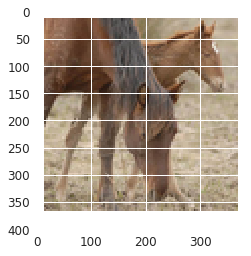

hartebeest: 42.98%
sorrel: 40.16%
Arabian camel, dromedary, Camelus dromedarius: 1.32%
worm fence, snake fence, snake-rail fence, Virginia fence: 0.56%
padlock: 0.30%


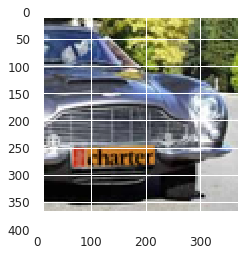

minivan: 19.62%
convertible: 17.34%
moving van: 6.69%
grille, radiator grille: 4.89%
limousine, limo: 4.36%


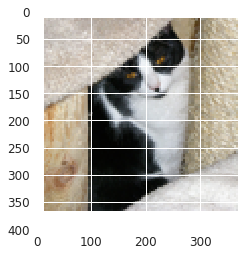

Egyptian cat: 23.62%
tiger cat: 10.26%
tabby, tabby cat: 7.95%
paper towel: 5.44%
space heater: 3.95%


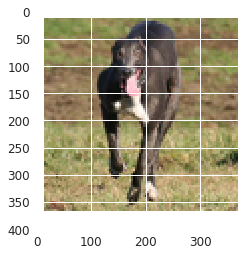

whippet: 55.57%
Great Dane: 22.42%
Scottish deerhound, deerhound: 4.23%
Labrador retriever: 2.19%
Staffordshire bullterrier, Staffordshire bull terrier: 1.72%


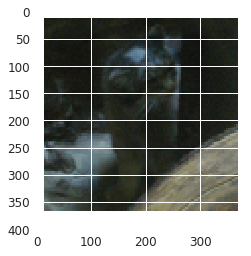

otter: 20.85%
fox squirrel, eastern fox squirrel, Sciurus niger: 11.69%
mink: 8.69%
wombat: 3.28%
weasel: 3.24%


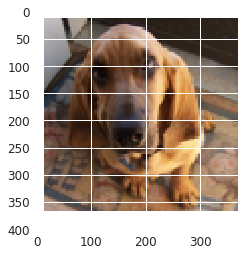

bloodhound, sleuthhound: 73.56%
redbone: 13.38%
basset, basset hound: 2.05%
Sussex spaniel: 0.73%
black-and-tan coonhound: 0.64%


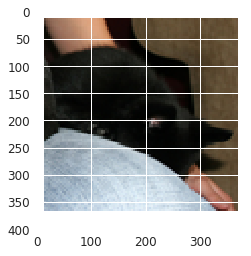

schipperke: 97.61%
groenendael: 1.40%
Chihuahua: 0.09%
Labrador retriever: 0.06%
kelpie: 0.06%


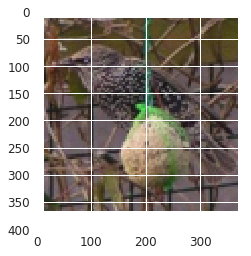

black grouse: 36.32%
coucal: 11.42%
prairie chicken, prairie grouse, prairie fowl: 8.54%
brambling, Fringilla montifringilla: 4.01%
partridge: 3.74%


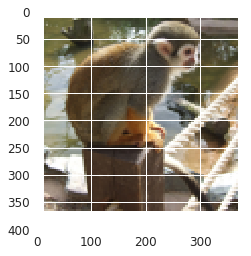

squirrel monkey, Saimiri sciureus: 54.54%
titi, titi monkey: 17.62%
patas, hussar monkey, Erythrocebus patas: 6.21%
spider monkey, Ateles geoffroyi: 6.11%
capuchin, ringtail, Cebus capucinus: 0.43%


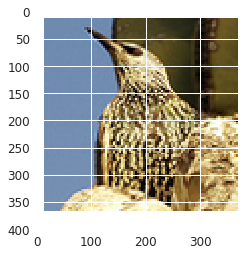

bustard: 5.88%
kite: 5.88%
prairie chicken, prairie grouse, prairie fowl: 5.84%
black grouse: 3.56%
coucal: 3.24%


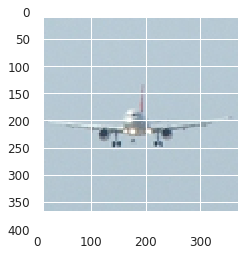

airliner: 93.48%
wing: 2.87%
space shuttle: 0.69%
warplane, military plane: 0.29%
gazelle: 0.04%


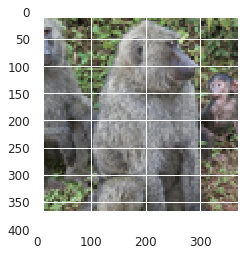

baboon: 62.16%
patas, hussar monkey, Erythrocebus patas: 3.86%
macaque: 3.03%
marmot: 1.63%
gorilla, Gorilla gorilla: 1.44%


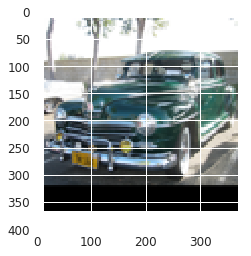

limousine, limo: 20.69%
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon: 16.45%
convertible: 16.13%
minivan: 3.26%
grille, radiator grille: 2.75%


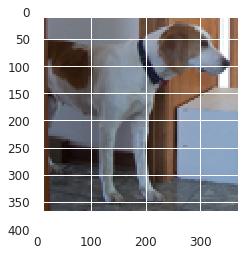

Walker hound, Walker foxhound: 51.45%
English foxhound: 35.92%
Brittany spaniel: 1.47%
redbone: 1.01%
beagle: 0.59%


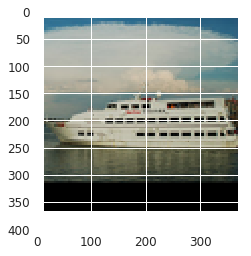

liner, ocean liner: 95.37%
dock, dockage, docking facility: 0.15%
seashore, coast, seacoast, sea-coast: 0.11%
catamaran: 0.09%
fireboat: 0.07%


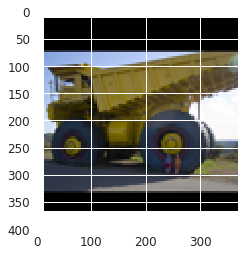

thresher, thrasher, threshing machine: 70.68%
tractor: 10.93%
harvester, reaper: 2.60%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 0.88%
lumbermill, sawmill: 0.63%


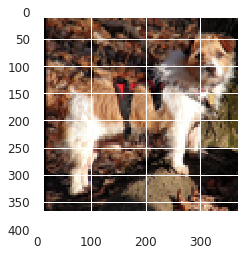

Japanese spaniel: 18.29%
papillon: 9.58%
Norwich terrier: 5.03%
toy terrier: 4.45%
fox squirrel, eastern fox squirrel, Sciurus niger: 2.37%


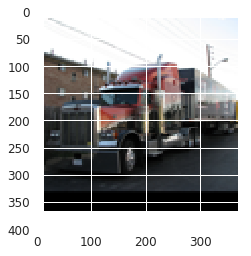

trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 80.59%
moving van: 7.91%
tow truck, tow car, wrecker: 0.39%
screen, CRT screen: 0.21%
garbage truck, dustcart: 0.21%


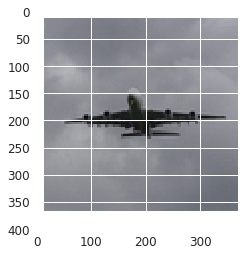

airliner: 90.21%
warplane, military plane: 1.59%
space shuttle: 0.27%
assault rifle, assault gun: 0.21%
wing: 0.18%


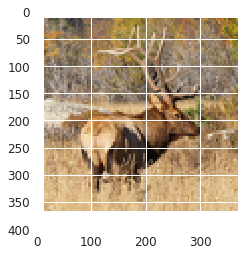

hartebeest: 76.64%
impala, Aepyceros melampus: 1.42%
ibex, Capra ibex: 1.34%
gazelle: 0.81%
dhole, Cuon alpinus: 0.14%


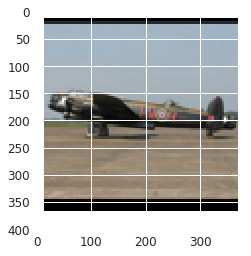

warplane, military plane: 80.75%
airliner: 4.63%
wing: 2.94%
aircraft carrier, carrier, flattop, attack aircraft carrier: 0.35%
airship, dirigible: 0.19%


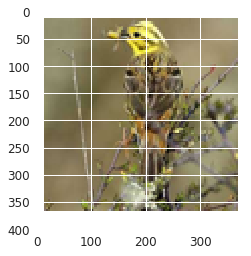

brambling, Fringilla montifringilla: 27.09%
barn spider, Araneus cavaticus: 25.85%
black grouse: 5.70%
black and gold garden spider, Argiope aurantia: 3.46%
ruffed grouse, partridge, Bonasa umbellus: 2.51%


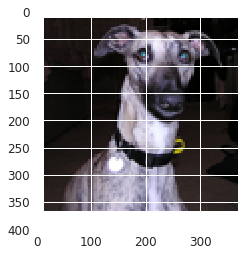

whippet: 88.30%
Italian greyhound: 3.18%
Saluki, gazelle hound: 0.71%
Mexican hairless: 0.38%
Ibizan hound, Ibizan Podenco: 0.35%


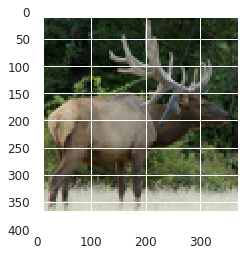

hartebeest: 72.32%
gazelle: 2.73%
ibex, Capra ibex: 2.53%
bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis: 1.51%
impala, Aepyceros melampus: 0.50%


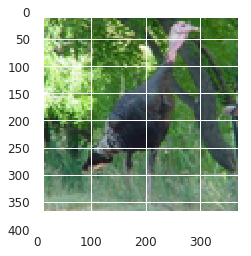

black stork, Ciconia nigra: 25.12%
three-toed sloth, ai, Bradypus tridactylus: 6.05%
crane: 4.83%
limpkin, Aramus pictus: 4.18%
peacock: 4.14%


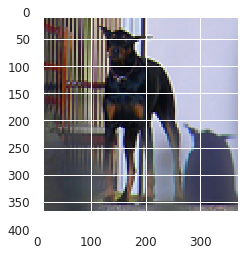

Doberman, Doberman pinscher: 85.67%
black-and-tan coonhound: 5.67%
Rottweiler: 2.35%
miniature pinscher: 0.89%
muzzle: 0.63%


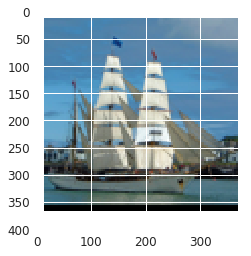

schooner: 75.08%
yawl: 15.77%
pirate, pirate ship: 1.09%
trimaran: 0.17%
Arctic fox, white fox, Alopex lagopus: 0.10%


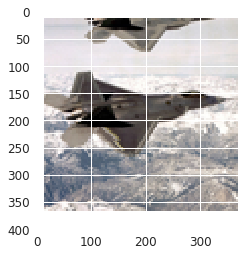

warplane, military plane: 77.12%
projectile, missile: 9.17%
aircraft carrier, carrier, flattop, attack aircraft carrier: 2.85%
missile: 0.93%
electric ray, crampfish, numbfish, torpedo: 0.66%


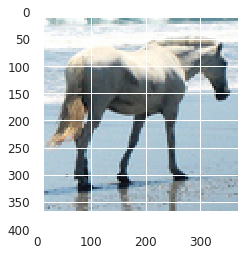

bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis: 18.70%
ox: 18.27%
hartebeest: 15.87%
gazelle: 7.22%
ibex, Capra ibex: 3.22%


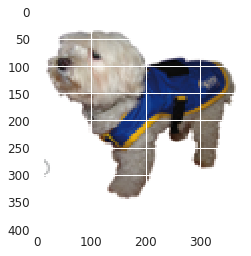

Maltese dog, Maltese terrier, Maltese: 61.49%
Dandie Dinmont, Dandie Dinmont terrier: 4.66%
Lhasa, Lhasa apso: 2.51%
Tibetan terrier, chrysanthemum dog: 1.39%
West Highland white terrier: 0.98%


In [137]:


with tf.Session() as sess:
  saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
  for idx, img in enumerate(X_test):
    plt.imshow(X_origin[idx])
    plt.show()
    img = img.reshape(-1, HEIGHT, WIDTH, CHANNELS)
    predictions_val = predictions.eval(feed_dict={X: img})
    top_5 = np.argpartition(predictions_val[0], -5)[-5:]
    top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
    for i in top_5:
      print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))
    

